In [2]:
from random import *
from math   import *
import enum
from textwrap import dedent
import numpy as np
from scipy.signal import firwin, firwin2, minimum_phase
import pandas as pd

In [3]:
class FiltType(enum.Enum):
   LP = 1
   BP = 2
   HP = 3

class Coeffs():
    def __init__(self, filt_type, taps, cutoffs, width, min_phase=False, type1=False, half_band=False):
        self.filt_type = filt_type
        self.min_phase = min_phase
        self.half_band = half_band
        self.type1 = type1
        self.taps = int(taps)
        self.cutoffs = cutoffs
        self.width = int(width)
    
    @property
    def coeffs(self):
        if self.filt_type == FiltType.LP:
            amps = [1,1,0,0]
            asym = False
        elif self.filt_type == FiltType.HP:
            amps = [0,0,1,1]
            asym = True
        elif self.filt_type == FiltType.BP:
            amps = [0,0,1,1,0,0]
            asym = True

        if self.min_phase:
            ws = minimum_phase(firwin2(self.taps*2, self.cutoffs, amps, antisymmetric=asym))
        elif self.type1:
            ws = firwin2(self.taps-1, self.cutoffs, amps, antisymmetric=asym)
            ws = np.append(ws, [0])
        elif self.half_band:
            ws = firwin(self.taps+1, 0.5)[1:]
        else:
            ws = firwin2(self.taps, self.cutoffs, amps, antisymmetric=asym)
        return np.round(ws * (2**(self.width-1)-1)).astype(int)
    
    @property
    def coeffs_vec(self):
        return '(' + ':>'.join([f'({c})' for c in self.coeffs]) + \
               f':> Nil :: Vec {len(self.coeffs)} (Signed {self.width}) )'
    
    @property
    def name(self):
        return self.filt_type.name + \
               '_N' + str(self.taps) + \
               '_F' + '-'.join(str(f) for f in self.cutoffs) + \
               '_CB' + str(self.width)

class FiltStructure(enum.Enum):
   PolyDir = 1
   PolyMcm = 2
   FfaDir  = 3
   FfaMcm  = 4

class FiltSpec():
    def __init__(self, structure, parallelism, width, coeffs):
        self.structure = structure
        self.p = parallelism
        self.width = width
        self.coeffs = coeffs
    
    @property
    def name(self):
        return self.structure.name + \
               '_P' + str(self.p) + \
               '_IB' + str(self.width) + \
               '_' + self.coeffs.name
    
    @property
    def subfilt_taps(self):
        return int(self.coeffs.taps / self.p)
    
    @property
    def _f_src(self):
        
        if self.structure == FiltStructure.PolyDir:
            return f"""
                   fir :: HiddenClockResetEnable dom
                       => Signal dom (Vec {self.p} (Signed {self.width}))
                       -> Signal dom (Vec {self.p} (Signed ({self.width} + {self.coeffs.width} + CLog 2 {self.subfilt_taps} + CLog 2 {self.p})))
                   fir xs = polyphase (SNat :: SNat {self.p}) firDirect (map resize $ {self.coeffs.coeffs_vec}) (fmap (map resize) xs)
                   """
        
        elif self.structure == FiltStructure.PolyMcm:
            return f"""
                   fir :: HiddenClockResetEnable dom
                       => Signal dom (Vec {self.p} (Signed {self.width}))
                       -> Signal dom (Vec {self.p} (Signed ({self.width} + {self.coeffs.width} + CLog 2 {self.subfilt_taps} + CLog 2 {self.p})))
                   fir xs = polyphase_MCM
                              (SNat :: SNat {self.p})
                              $(mcmPipelinedDepthHwTH HcubShallow 3 (toList $ map fromIntegral {self.coeffs.coeffs_vec}))
                              (fmap (map resize) xs)
                   """
        elif self.structure == FiltStructure.FfaDir:
            return f"""
                   fir :: HiddenClockResetEnable dom
                       => Signal dom (Vec {self.p} (Signed {self.width}))
                       -> Signal dom (Vec {self.p} (Signed ({self.width} + {self.coeffs.width} + CLog 2 {self.subfilt_taps}+ 4*(CLog 2 {self.p}))))
                   fir xs = $(genFFA (SNat :: SNat {self.p}))
                                firDirect
                                (map resize {self.coeffs.coeffs_vec})
                                (fmap (map resize) xs)
                   """
        elif self.structure == FiltStructure.FfaMcm:
            return f"""
                   fir :: HiddenClockResetEnable dom
                       => Signal dom (Vec {self.p} (Signed {self.width}))
                       -> Signal dom (Vec {self.p} (Signed ({self.width} + {self.coeffs.width} + CLog 2 {self.subfilt_taps}+ 4*(CLog 2 {self.p}))))
                   fir xs = $(genFFA_MCM (mcmPipelinedDepthHwTH HcubShallow 3)
                                         (SNat :: SNat {self.p})
                                         (map fromIntegral {self.coeffs.coeffs_vec})
                            ) (fmap (map resize) xs)
                   """

    @property
    def src(self):
        return dedent("""
               import Clash.Prelude
               import Filter.FFA
               import Filter.Serial
               import Filter.Polyphase
               import Graph.MCM
               
               createDomain vSystem{vName="SystemNR", vResetPolarity=ActiveLow}
               
               """) + dedent(self._f_src) + dedent("""
               {-# ANN topEntity
                 (Synthesize
                   { t_name   = "fir_dut"
                   , t_inputs = [ PortName "clk"
                                , PortName "rst"
                                , PortName "x" ]
                   , t_output = PortName "y"
                   }) #-}
               topEntity c r x = exposeClockResetEnable (fir @SystemNR x) c r (toEnable $ pure True)
               """)

In [4]:
def run_synth(test_group, fir, src_exist=False):
    print(f'Starting {test_group}/{fir.name}')
    synth_dir = f'./outputs/{test_group}/{fir.name}'
    if not src_exist:
        !mkdir -p {synth_dir}
        !cp -r ../synth/* {synth_dir}/
        with open(f'{synth_dir}/Filter.hs', 'w') as f:
                f.write(fir.src)
    !nix-shell --command 'make -C {synth_dir}' ../shell.nix &> {synth_dir}/build.log

In [6]:
# First test where we loop through all the filtTypes and parallelisms for 64 coeffs
for parallelism in [2,4,8,16]:
    for filtStruct in FiltStructure:
        ws = Coeffs(FiltType.LP, 32, [0,0.3,0.4,1.0], 16)
        fir = FiltSpec(filtStruct, parallelism, 16, ws)
        run_synth('all_strucs_all_par_taps32_linphase', fir)

Starting all_strucs_all_par_taps32_linphase/PolyDir_P2_IB16_LP_N32_F0-0.3-0.4-1.0_CB16
Starting all_strucs_all_par_taps32_linphase/PolyMcm_P2_IB16_LP_N32_F0-0.3-0.4-1.0_CB16
Starting all_strucs_all_par_taps32_linphase/FfaDir_P2_IB16_LP_N32_F0-0.3-0.4-1.0_CB16
Starting all_strucs_all_par_taps32_linphase/FfaMcm_P2_IB16_LP_N32_F0-0.3-0.4-1.0_CB16
Starting all_strucs_all_par_taps32_linphase/PolyDir_P4_IB16_LP_N32_F0-0.3-0.4-1.0_CB16
Starting all_strucs_all_par_taps32_linphase/PolyMcm_P4_IB16_LP_N32_F0-0.3-0.4-1.0_CB16
Starting all_strucs_all_par_taps32_linphase/FfaDir_P4_IB16_LP_N32_F0-0.3-0.4-1.0_CB16
Starting all_strucs_all_par_taps32_linphase/FfaMcm_P4_IB16_LP_N32_F0-0.3-0.4-1.0_CB16
Starting all_strucs_all_par_taps32_linphase/PolyDir_P8_IB16_LP_N32_F0-0.3-0.4-1.0_CB16
Starting all_strucs_all_par_taps32_linphase/PolyMcm_P8_IB16_LP_N32_F0-0.3-0.4-1.0_CB16
Starting all_strucs_all_par_taps32_linphase/FfaDir_P8_IB16_LP_N32_F0-0.3-0.4-1.0_CB16
Starting all_strucs_all_par_taps32_linphase/FfaM

In [45]:
for parallelism in [2,4,8,16]:
    for taps in [2,4,8,16,32,64,128]:
        if parallelism > taps:
            continue
        for filtStruct in FiltStructure:
            ws = Coeffs(FiltType.LP, taps, [0,0.3,0.4,1.0], 16, min_phase=True)
            fir = FiltSpec(filtStruct, parallelism, 16, ws)
            run_synth(f'all_strucs_var_taps_par{parallelism}_minphase', fir)

Starting all_strucs_var_taps_par16_minphase/PolyDir_P16_IB16_LP_N16_F0-0.3-0.4-1.0_CB16
Starting all_strucs_var_taps_par16_minphase/PolyMcm_P16_IB16_LP_N16_F0-0.3-0.4-1.0_CB16
Starting all_strucs_var_taps_par16_minphase/FfaDir_P16_IB16_LP_N16_F0-0.3-0.4-1.0_CB16
Starting all_strucs_var_taps_par16_minphase/FfaMcm_P16_IB16_LP_N16_F0-0.3-0.4-1.0_CB16
Starting all_strucs_var_taps_par16_minphase/PolyDir_P16_IB16_LP_N32_F0-0.3-0.4-1.0_CB16
Starting all_strucs_var_taps_par16_minphase/PolyMcm_P16_IB16_LP_N32_F0-0.3-0.4-1.0_CB16
Starting all_strucs_var_taps_par16_minphase/FfaDir_P16_IB16_LP_N32_F0-0.3-0.4-1.0_CB16
Starting all_strucs_var_taps_par16_minphase/FfaMcm_P16_IB16_LP_N32_F0-0.3-0.4-1.0_CB16
Starting all_strucs_var_taps_par16_minphase/PolyDir_P16_IB16_LP_N64_F0-0.3-0.4-1.0_CB16
Starting all_strucs_var_taps_par16_minphase/PolyMcm_P16_IB16_LP_N64_F0-0.3-0.4-1.0_CB16
Starting all_strucs_var_taps_par16_minphase/FfaDir_P16_IB16_LP_N64_F0-0.3-0.4-1.0_CB16
Starting all_strucs_var_taps_par16_mi

In [ ]:
for parallelism in [2,4,8,16]:
    for taps in [2,4,8,16,32,64,128]:
        if parallelism > taps:
            continue
        for filtStruct in FiltStructure:
            ws = Coeffs(FiltType.LP, taps, [0,0.3,0.4,1.0], 16)
            fir = FiltSpec(filtStruct, parallelism, 16, ws)
            run_synth(f'all_strucs_var_taps_par{parallelism}_linphase', fir) #Really type II...

In [46]:
for parallelism in [2,4,8,16]:
    for taps in [2,4,8,16,32,64,128]:
        if parallelism > taps:
            continue
        for filtStruct in FiltStructure:
            ws = Coeffs(FiltType.LP, taps, [0,0.3,0.4,1.0], 16, type1=True)
            fir = FiltSpec(filtStruct, parallelism, 16, ws)
            run_synth(f'all_strucs_var_taps_par{parallelism}_type1', fir)

Starting all_strucs_var_taps_par2_type1/PolyDir_P2_IB16_LP_N2_F0-0.3-0.4-1.0_CB16
Starting all_strucs_var_taps_par2_type1/PolyMcm_P2_IB16_LP_N2_F0-0.3-0.4-1.0_CB16
Starting all_strucs_var_taps_par2_type1/FfaDir_P2_IB16_LP_N2_F0-0.3-0.4-1.0_CB16
Starting all_strucs_var_taps_par2_type1/FfaMcm_P2_IB16_LP_N2_F0-0.3-0.4-1.0_CB16
Starting all_strucs_var_taps_par2_type1/PolyDir_P2_IB16_LP_N4_F0-0.3-0.4-1.0_CB16
Starting all_strucs_var_taps_par2_type1/PolyMcm_P2_IB16_LP_N4_F0-0.3-0.4-1.0_CB16
Starting all_strucs_var_taps_par2_type1/FfaDir_P2_IB16_LP_N4_F0-0.3-0.4-1.0_CB16
Starting all_strucs_var_taps_par2_type1/FfaMcm_P2_IB16_LP_N4_F0-0.3-0.4-1.0_CB16
Starting all_strucs_var_taps_par2_type1/PolyDir_P2_IB16_LP_N8_F0-0.3-0.4-1.0_CB16
Starting all_strucs_var_taps_par2_type1/PolyMcm_P2_IB16_LP_N8_F0-0.3-0.4-1.0_CB16
Starting all_strucs_var_taps_par2_type1/FfaDir_P2_IB16_LP_N8_F0-0.3-0.4-1.0_CB16
Starting all_strucs_var_taps_par2_type1/FfaMcm_P2_IB16_LP_N8_F0-0.3-0.4-1.0_CB16
Starting all_strucs_va

In [5]:
for parallelism in [2,4,8,16]:
    for taps in [2,4,8,16,32,64,128]:
        if parallelism > taps:
            continue
        for filtStruct in FiltStructure:
            ws = Coeffs(FiltType.LP, taps, [0,0.3,0.4,1.0], 16, half_band=True)
            fir = FiltSpec(filtStruct, parallelism, 16, ws)
            run_synth(f'all_strucs_var_taps_par{parallelism}_hb', fir)

Starting all_strucs_var_taps_par2_hb/PolyDir_P2_IB16_LP_N2_F0-0.3-0.4-1.0_CB16
Starting all_strucs_var_taps_par2_hb/PolyMcm_P2_IB16_LP_N2_F0-0.3-0.4-1.0_CB16
Starting all_strucs_var_taps_par2_hb/FfaDir_P2_IB16_LP_N2_F0-0.3-0.4-1.0_CB16
Starting all_strucs_var_taps_par2_hb/FfaMcm_P2_IB16_LP_N2_F0-0.3-0.4-1.0_CB16
Starting all_strucs_var_taps_par2_hb/PolyDir_P2_IB16_LP_N4_F0-0.3-0.4-1.0_CB16
Starting all_strucs_var_taps_par2_hb/PolyMcm_P2_IB16_LP_N4_F0-0.3-0.4-1.0_CB16
Starting all_strucs_var_taps_par2_hb/FfaDir_P2_IB16_LP_N4_F0-0.3-0.4-1.0_CB16
Starting all_strucs_var_taps_par2_hb/FfaMcm_P2_IB16_LP_N4_F0-0.3-0.4-1.0_CB16
Starting all_strucs_var_taps_par2_hb/PolyDir_P2_IB16_LP_N8_F0-0.3-0.4-1.0_CB16
Starting all_strucs_var_taps_par2_hb/PolyMcm_P2_IB16_LP_N8_F0-0.3-0.4-1.0_CB16
Starting all_strucs_var_taps_par2_hb/FfaDir_P2_IB16_LP_N8_F0-0.3-0.4-1.0_CB16
Starting all_strucs_var_taps_par2_hb/FfaMcm_P2_IB16_LP_N8_F0-0.3-0.4-1.0_CB16
Starting all_strucs_var_taps_par2_hb/PolyDir_P2_IB16_LP_N1

In [6]:
slice_regs = []

for parallelism in [2,4,8,16]:
    for taps in [2,4,8,16,32,64,128]:
        if parallelism > taps:
            continue
        #if taps > 8*parallelism:
        #    continue
        for filtStruct in FiltStructure:
            ws = Coeffs(FiltType.LP, taps, [0,0.3,0.4,1.0], 16, half_band=True)
            fir = FiltSpec(filtStruct, parallelism, 16, ws)
            
            group = f'all_strucs_var_taps_par{parallelism}_hb'
            results_dir = f'./outputs/{group}/{fir.name}'
            
            lut_cmd = f'grep "CLB LUTs" {results_dir}/post_route_util.rpt | cut -d"|" -f3'
            lut_result=!$lut_cmd
            reg_cmd = f'grep "CLB Registers" {results_dir}/post_route_util.rpt | head -n 1 | cut -d"|" -f3'
            reg_result=!$reg_cmd
            clb_cmd = f'grep "| CLB  " {results_dir}/post_route_util.rpt | head -n 1 | cut -d"|" -f3'
            clb_result=!$clb_cmd
            dsp_cmd = f'grep "| DSPs  " {results_dir}/post_route_util.rpt | head -n 1 | cut -d"|" -f3'
            dsp_result=!$dsp_cmd

            try:
                slice_regs.append({
                    'group': group,
                    'name': fir.name,
                    'filt_type': fir.coeffs.filt_type.name,
                    'in_width': fir.width,
                    'f_ranges': fir.coeffs.cutoffs,
                    'c_width': fir.coeffs.width,
                    'structure': fir.structure.name,
                    'parallelism': fir.p,
                    'taps': fir.coeffs.taps,
                    'luts' : int(lut_result.s),
                    'regs' : int(reg_result.s),
                    'clbs' : int(clb_result.s),
                    'dsps' : int(dsp_result.s),
                })
            except:
                print(f"Couldn't parse result for {fir.name}. Did it fail synthesis?")
                print(f"Rerunning now")
                run_synth(group, fir, src_exist=True)

df = pd.DataFrame(slice_regs)

Couldn't parse result for PolyMcm_P8_IB16_LP_N16_F0-0.3-0.4-1.0_CB16. Did it fail synthesis?
Rerunning now
Starting all_strucs_var_taps_par8_hb/PolyMcm_P8_IB16_LP_N16_F0-0.3-0.4-1.0_CB16


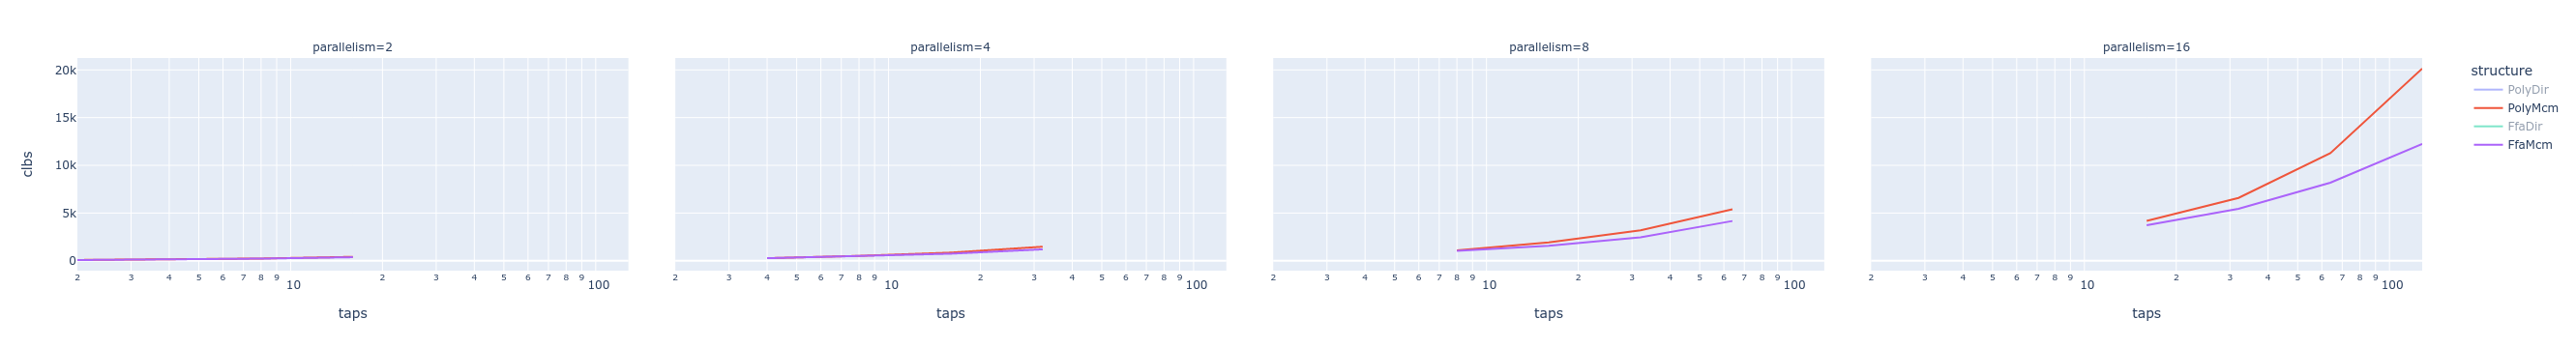

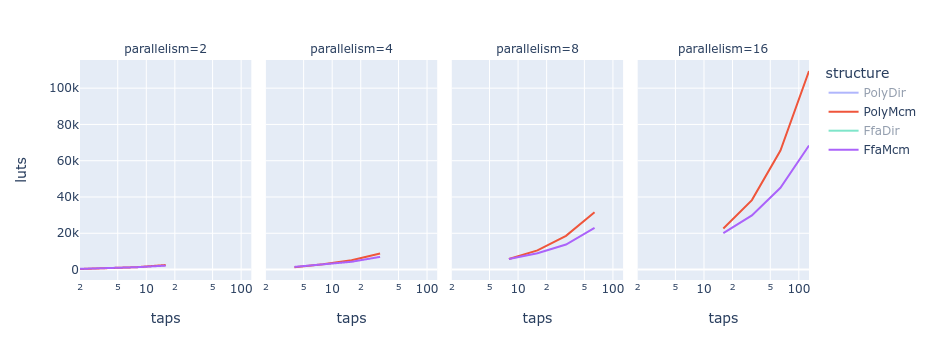

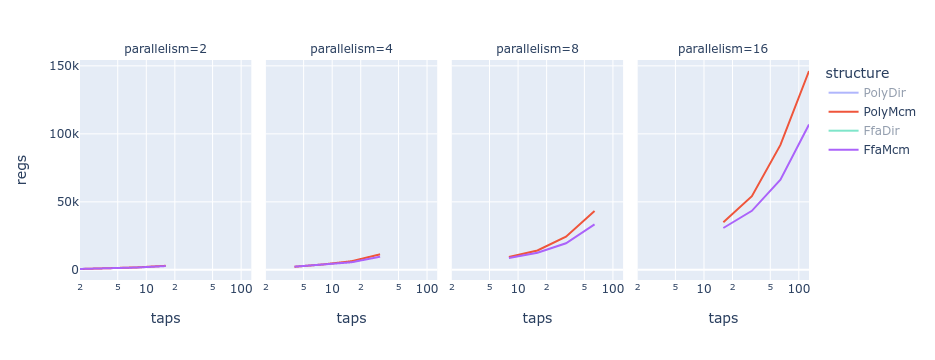

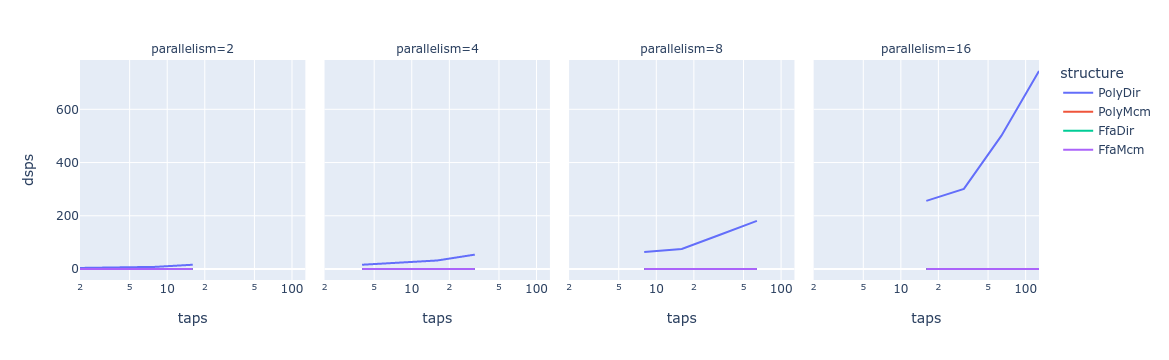

In [45]:
import plotly.express as px
display(px.line(df, x='taps', facet_col='parallelism',y='clbs', color='structure', log_x=True))
display(px.line(df, x='taps', facet_col='parallelism',y='luts', color='structure', log_x=True))
display(px.line(df, x='taps', facet_col='parallelism',y='regs', color='structure', log_x=True))
display(px.line(df, x='taps', facet_col='parallelism',y='dsps', color='structure', log_x=True))